In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

# Preprocessing
- Join the two dataframes
- Fix the picture paths
- Label extraction from the fixed paths
- conversion of data into a pandas dataframe for convenience
- Generate tensor image data in batches while adding real-time data augmentation using `ImageDataGenerator`.

## Data Retrieval

In [4]:
#get the soybean crops images and their corresponding labels

soybean_dataset_path = Path("/kaggle/input", "weed-detection-in-soybean-crops")
soy_images = list(soybean_dataset_path.glob(r'**/*.tif'))
soy_labels = [x.parents[0].stem for x in soy_images]

In [5]:
# get the plant seedling images and their corresponding labels

dataset_path = Path("/kaggle/input")
images = list(dataset_path.glob(r'**/*.png'))
labels = list(map(lambda x: x.parents[0].stem, images))

In [6]:
# getting the plant seedling dataset in a Dataframe for convenience

seedling_images = pd.Series(images, name="Images").astype(str)
seedling_labels = pd.Series(labels, name="Labels").astype(str)

seedling_data = pd.concat([seedling_images, seedling_labels], axis = 1)
seedling_data = seedling_data.sample(frac = 1, random_state = 42).reset_index(drop = True)
seedling_data.head()

,Images,Labels
0,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Small-flowered Cranesbill
1,/kaggle/input/v2-plant-seedlings-dataset/Commo...,Common Chickweed
2,/kaggle/input/v2-plant-seedlings-dataset/Loose...,Loose Silky-bent
3,/kaggle/input/v2-plant-seedlings-dataset/Black...,Black-grass
4,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Sugar beet


In [7]:
soy_images = pd.Series(soy_images, name="Images").astype(str)
soy_labels = pd.Series(soy_labels, name="Labels").astype(str)

soy_data = pd.concat([soy_images, soy_labels], axis=1)
soy_data = soy_data.sample(frac = 1, random_state=42).reset_index(drop = True)
soy_data.head()

,Images,Labels
0,/kaggle/input/weed-detection-in-soybean-crops/...,grass
1,/kaggle/input/weed-detection-in-soybean-crops/...,broadleaf
2,/kaggle/input/weed-detection-in-soybean-crops/...,soybean
3,/kaggle/input/weed-detection-in-soybean-crops/...,soil
4,/kaggle/input/weed-detection-in-soybean-crops/...,soybean


In [8]:
##Concatenating the two datasets to form the final dataset
final_images = soy_data['Images'].append(seedling_data['Images'], ignore_index = True)
final_labels = soy_data['Labels'].append(seedling_data['Labels'], ignore_index = True)

final_data = pd.DataFrame(data = {'Images': final_images, 'Labels': final_labels})
display(final_data)

,Images,Labels
0,/kaggle/input/weed-detection-in-soybean-crops/...,grass
1,/kaggle/input/weed-detection-in-soybean-crops/...,broadleaf
2,/kaggle/input/weed-detection-in-soybean-crops/...,soybean
3,/kaggle/input/weed-detection-in-soybean-crops/...,soil
4,/kaggle/input/weed-detection-in-soybean-crops/...,soybean
...,...,...
41745,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Small-flowered Cranesbill
41746,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Fat Hen
41747,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Fat Hen
41748,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Scentless Mayweed


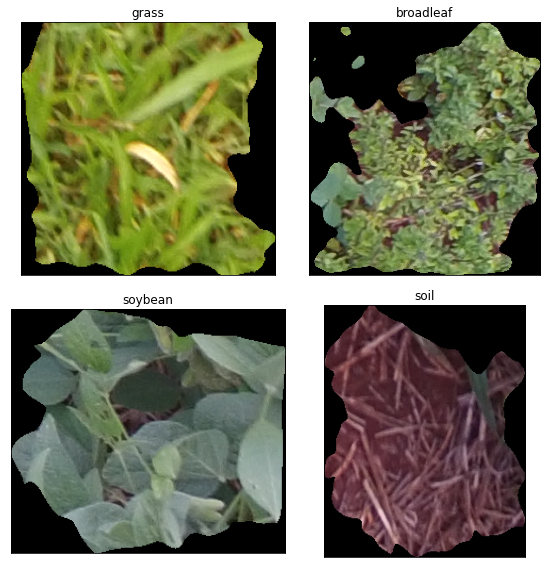

In [9]:
#Viewing some of the images in the dataframe
fig, axes = plt.subplots(2, 2, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(imageio.imread(final_data.Images[i]))
    ax.set_title(final_data.Labels[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## Data Augmentations
> For MobileNets the input image size used is (224, 224, 3)

- Horizontal Flipping
- Shearing
- Scaling
- Translation
- Rotation
- Brightness Shift

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet

train_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet.preprocess_input,
    validation_split = 0.1
)

test_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet.preprocess_input
)

In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(final_data, train_size=0.7, shuffle=True, random_state=42, stratify=final_data[["Labels"]])

train = train_generator_mobile_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    fill_mode="nearest"
)

validation = train_generator_mobile_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    fill_mode="nearest"
)

test = test_generator_mobile_net.flow_from_dataframe(
    dataframe=test_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shuffle=False
)

Found 26302 validated image filenames belonging to 16 classes.
Found 2922 validated image filenames belonging to 16 classes.
Found 12526 validated image filenames belonging to 16 classes.


# Building the Model

## [MobileNet](https://arxiv.org/abs/1704.04861)

The MobileNet model is TensorFlow's first mobile computer vision model, and as the name
suggests, it is created to be utilized in mobile applications. Depth-wise separable convolutions
are used by MobileNet[109]. When compared to a network with conventional convolutions of
the same depth in the nets, it dramatically decreases the number of parameters. Light deep neural
networks are the outcome of this. We have a good starting point for training insanely tiny and
fast classifiers since MobileNet is a kind of CNN that Google open-sourced. 

MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks. This reduces the number of parameters needed and the corresponding computation in convolution and learning. Each convolution operation is seprated into a depthwise convolution (doesn't affect the number of channels) and a pointwise convolution (doesn't affect the size of each channel). The main difference between 2D convolutions and Depthwise Convolution is that 2D convolutions are performed over all/multiple input channels, whereas in Depthwise convolution, each channel is kept separate.

In [12]:
import tensorflow as tf

In [13]:
#using MobileNet

from tensorflow.keras.applications import mobilenet

mobilenet_ = mobilenet.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    alpha=1.0,
    weights='imagenet',
    pooling='avg'
)

mobilenet_.trainable = False

17235968/17225924 [==============================] - 0s 0us/step


In [14]:
CHECKPOINTS = Path("./checkpoints")
CHECKPOINTS.mkdir(exist_ok=True)

In [15]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# building the Predictor layers
x = Dense(128, activation='relu')(mobilenet_.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

outputs = Dense(16, activation='softmax')(x)

mobilenet = Model(inputs=mobilenet_.inputs, outputs=outputs)

mobilenet.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

with tf.device('/GPU:0'):
# training
    results = mobilenet.fit(
        train,
        validation_data = validation,
        batch_size = 32,
        epochs = 10,
        callbacks = [EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ), ReduceLROnPlateau(patience=2)]
    )

2023-01-20 18:22:16.197179: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-20 18:22:19.085673: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


822/822 [==============================] - 376s 447ms/step - loss: 0.2654 - categorical_accuracy: 0.9099 - val_loss: 0.1396 - val_categorical_accuracy: 0.9500
Epoch 2/10
822/822 [==============================] - 192s 233ms/step - loss: 0.1113 - categorical_accuracy: 0.9619 - val_loss: 0.1011 - val_categorical_accuracy: 0.9648
Epoch 3/10
822/822 [==============================] - 190s 231ms/step - loss: 0.0824 - categorical_accuracy: 0.9706 - val_loss: 0.1238 - val_categorical_accuracy: 0.9572
Epoch 4/10
822/822 [==============================] - 189s 229ms/step - loss: 0.0607 - categorical_accuracy: 0.9786 - val_loss: 0.1170 - val_categorical_accuracy: 0.9613
Epoch 5/10
822/822 [==============================] - 187s 228ms/step - loss: 0.0217 - categorical_accuracy: 0.9931 - val_loss: 0.0537 - val_categorical_accuracy: 0.9825
Epoch 6/10
822/822 [==============================] - 192s 233ms/step - loss: 0.0141 - categorical_accuracy: 0.9957 - val_loss: 0.0490 - val_categorical_accuracy

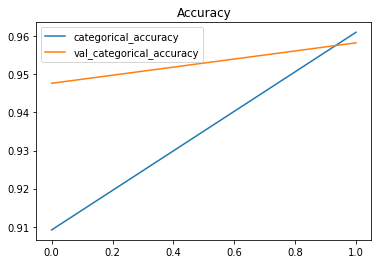

In [18]:
pd.DataFrame(results.history)[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()

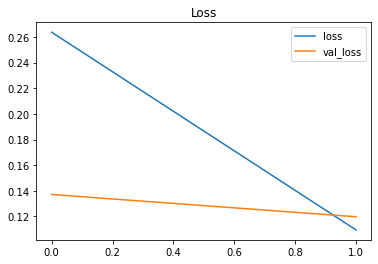

In [20]:
pd.DataFrame(results.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [18]:
mobilenet.save('kevin_mobilenet.h5')

In [ ]:
MODEL_PATH = Path("./saved_model")
MODEL_PATH.mkdir(exist_ok=True)
mobilenet.save(str(MODEL_PATH))

In [ ]:
# dump the training history as well
np.save('model_history.npy', results.history)

# history=np.load('model_history.npy',allow_pickle='TRUE').item()

# Model Evaluation

In [19]:
# Testing the model
results = mobilenet.evaluate(test)

392/392 [==============================] - 168s 429ms/step - loss: 0.0511 - categorical_accuracy: 0.9863


In [20]:
predictions = np.argmax(mobilenet.predict(test), axis=1)

### Classification Report

In [21]:
from sklearn.metrics import classification_report
labels = dict((v, k) for k, v in train.class_indices.items())
actual = list(test_df.Labels)
predictions = [labels[i] for i in predictions]
print(classification_report(actual, predictions))

                           precision    recall  f1-score   support

              Black-grass       0.88      0.79      0.83       185
                 Charlock       0.99      0.98      0.98       271
                 Cleavers       0.97      1.00      0.98       201
         Common Chickweed       0.97      0.99      0.98       428
             Common wheat       0.97      0.95      0.96       152
                  Fat Hen       0.95      0.97      0.96       323
         Loose Silky-bent       0.91      0.97      0.94       457
                    Maize       0.98      0.99      0.98       154
        Scentless Mayweed       0.98      0.95      0.96       364
         Shepherd’s Purse       0.95      0.89      0.92       164
Small-flowered Cranesbill       0.99      0.99      0.99       346
               Sugar beet       0.97      0.95      0.96       278
                broadleaf       1.00      0.98      0.99       715
                    grass       0.99      1.00      0.99     

### Confusion Matrix

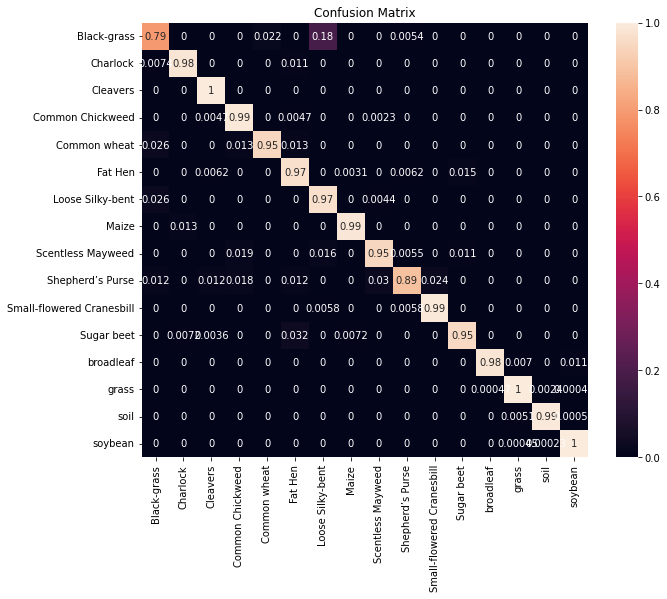

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf = confusion_matrix(actual, predictions, normalize = "true")
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, xticklabels = sorted(set(actual)), yticklabels = sorted(set(actual)))
plt.title('Confusion Matrix')
plt.show()